In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
team = pd.read_csv('core/Teams.csv')

In [3]:
team.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,...,24,0.834,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,...,16,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,...,15,0.818,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,...,8,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,...,14,0.840,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


In [4]:
ws = team[['name','WSWin']].copy().dropna()
ws.head()

,name,WSWin
125,Buffalo Bisons,N
126,Baltimore Orioles,N
128,Brooklyn Atlantics,N
129,Boston Beaneaters,N
131,Chicago White Stockings,N


In [5]:
ws['WSWin_Boolean'] = ws['WSWin'].apply(lambda x : True if x=='Y' else False)
ws.head()

,name,WSWin,WSWin_Boolean
125,Buffalo Bisons,N,False
126,Baltimore Orioles,N,False
128,Brooklyn Atlantics,N,False
129,Boston Beaneaters,N,False
131,Chicago White Stockings,N,False


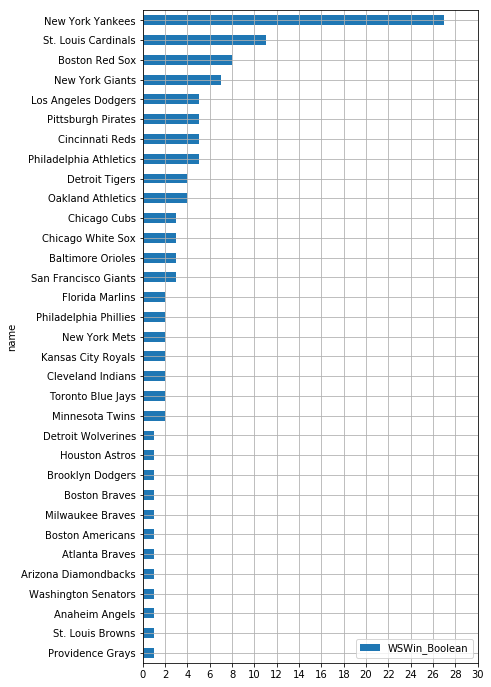

In [6]:
group = ws[['name','WSWin_Boolean']].groupby('name').agg('sum').sort_values('WSWin_Boolean')
group[group.any(axis='columns')].plot.barh(figsize=(6,12))
plt.xticks(range(0,31,2))
plt.grid()
plt.show()

In [7]:
team["win_odd"] = team["W"] / team["G"]
team["bav"] = team["H"] / team["AB"]

In [8]:
import statsmodels.formula.api as smf
result = smf.ols('win_odd~ERA+bav',data = team[(team['yearID']<=2018) & (team['yearID']>=1903)]).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                win_odd   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     1313.
Date:                Mon, 03 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:20:41   Log-Likelihood:                 3606.5
No. Observations:                2480   AIC:                            -7207.
Df Residuals:                    2477   BIC:                            -7190.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0160      0.019     -0.836      0.4

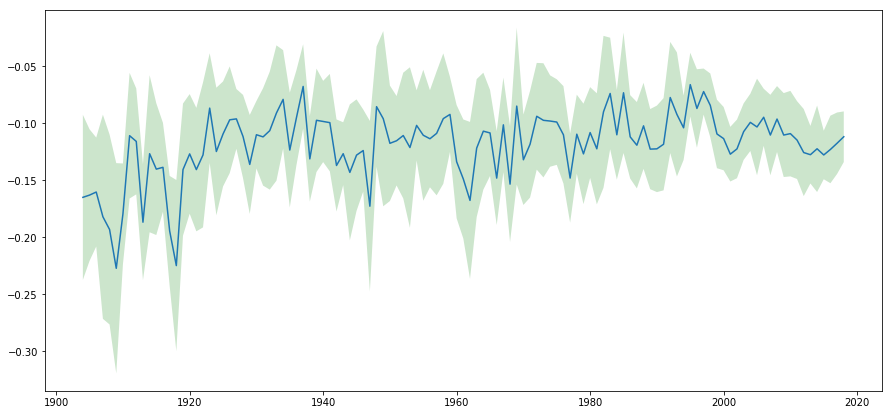

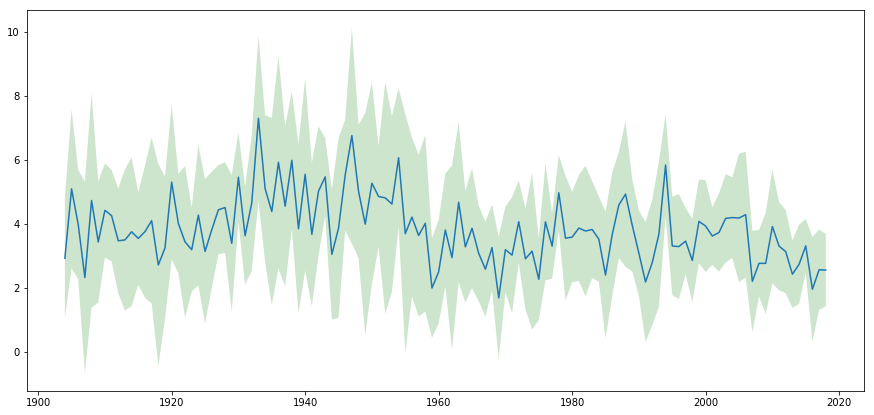

In [9]:
#假設Yit與Xit's的關係會隨著時間變動

#創建results_new變數來儲存統計結果
results_new = [None]*(2018-1903)

#創造兩個變數用來儲存era及bav逐年的coefficient
beta_era = np.zeros(((2018-1903), 1))
beta_bav = np.zeros(((2018-1903), 1))

#創造兩個變數用來儲存era及bav逐年的coefficient的信賴區間
beta_era_ci = np.zeros((2018-1903, 2))
beta_bav_ci = np.zeros((2018-1903, 2))

#將逐年的數據儲存到對應的變數當中
for i in range(1903, 2018, 1):
    results_new[i-1903] = smf.ols("win_odd~ERA+bav", data = team[team["yearID"] == i]).fit()
    beta_era[i-1903, 0] = results_new[i-1903].params[1]
    beta_bav[i-1903, 0] = results_new[i-1903].params[2]
    beta_era_ci[i-1903, 0:2] = np.array(results_new[i-1903].conf_int().iloc[1,], ndmin = 2)
    beta_bav_ci[i-1903, 0:2] = np.array(results_new[i-1903].conf_int().iloc[2,], ndmin = 2)
    
#將beta_era與beta_era_ci組合成一個DataFrame物件
df_era = pd.concat([pd.DataFrame(beta_era), pd.DataFrame(beta_era_ci)], axis = 1)
df_bav = pd.concat([pd.DataFrame(beta_bav), pd.DataFrame(beta_bav_ci)], axis = 1)

#為剛剛的DataFrame物件增加1903~2018的datatime index
df_era.index = pd.date_range(start = "1903", end = "2018", freq = "A")
df_bav.index = pd.date_range(start = "1903", end = "2018", freq = "A")

plt.figure(figsize = (15, 7))
#將ERA曲線本身以及信賴區間的範圍畫出來
plt.plot_date(df_era.index, df_era.iloc[:,0], "-")
era_lower = df_era.iloc[:,1]
era_upper = df_era.iloc[:,2]
plt.fill_between(df_era.index, era_upper, era_lower, facecolor = "green", alpha = 0.2, interpolate = True)
plt.show()

plt.figure(figsize = (15, 7))
#將bav曲線本身以及信賴區間的範圍畫出來
plt.plot_date(df_bav.index, df_bav.iloc[:,0], "-")
bav_lower = df_bav.iloc[:,1]
bav_upper = df_bav.iloc[:,2]
plt.fill_between(df_bav.index, bav_lower, bav_upper, facecolor = "green", alpha = 0.2, interpolate = True)
plt.show()

<Figure size 1080x504 with 0 Axes>

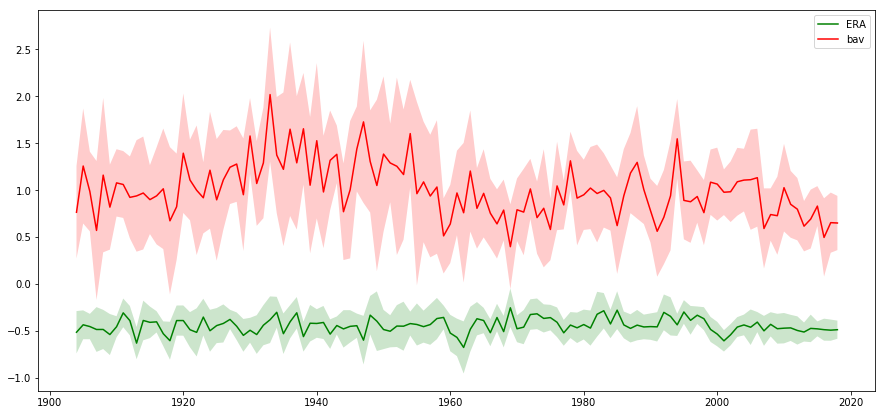

In [10]:
#建立空的list，預計將逐年的聯盟era及bav平均值儲存進來
teams_mean_era_by_year = []
teams_mean_bav_by_year = []

plt.figure(figsize = (15, 7))
#將1903~2017的對應資料逐年append至前面所建立的空list當中
for year in range(1903, 2018, 1):
    teams_mean_era_by_year.append(team.loc[team["yearID"] == year, "ERA"].mean())
    teams_mean_bav_by_year.append(team.loc[team["yearID"] == year, "bav"].mean())

#將逐年的信賴區間的上界下界乘以逐年的era與bav的平均數據
#由於list之間不能相乘，所以必須把teams_mean_era_by_year及teams_mean_bav_by_year先轉成np.array來與beta相乘計算
lower_era = beta_era_ci[:,0] * np.array(teams_mean_era_by_year)
upper_era = beta_era_ci[:,1] * np.array(teams_mean_era_by_year)
lower_bav = beta_bav_ci[:,0] * np.array(teams_mean_bav_by_year)
upper_bav = beta_bav_ci[:,1] * np.array(teams_mean_bav_by_year)


plt.figure(figsize = (15, 7))
#ERA
plt.plot_date(df_era.index, beta_era[:,0] * np.array(teams_mean_era_by_year), "-", color = "green",label="ERA")
plt.fill_between(df_era.index, lower_era, upper_era, facecolor = "green", alpha = 0.2, interpolate = True)

#BAV
plt.plot_date(df_bav.index, beta_bav[:,0] * np.array(teams_mean_bav_by_year), "-", color = "red",label="bav")
plt.fill_between(df_bav.index, lower_bav, upper_bav, facecolor = "red", alpha = 0.2, interpolate = True)

plt.legend()
plt.show()